> Interactive online version: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mTh6_YEgCRl6DAKqnmRp2XMOW8CTCvm7?usp=sharing)

# Quickstart example

In this notebook you will learn the basics of using `p-winds` to model the upper atmosphere (up to many planetary radii) of a H/He-dominated planet, and go all the way to calculating the transit signal in the Helium triplet at 1.083$\mu$m based on an atmospheric escape model.

`p-winds` is largely based on the theoretical framework of [Oklopčić & Hirata (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...855L..11O/abstract) and [Lampón et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..13L/abstract), which themselves based their work on the stellar wind model of [Parker (1958)](https://ui.adsabs.harvard.edu/abs/1958ApJ...128..664P/abstract). Some of the radiative transfer calculations were based on [Koskinen et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...723..116K/abstract) and [Allan & Vidotto (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.490.3760A/abstract).

**Notice**: `p-winds` is not suitable for simulations of the lower atmosphere (above $\sim 10^{-7}$ bar). Also, this page is a Jupyter notebook, and you can download it [here](https://raw.githubusercontent.com/ladsantos/p-winds/main/docs/source/quickstart.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.units as u
import astropy.constants as c
from p_winds import tools, parker, hydrogen, helium, transit, microphysics

# Uncomment the next line if you have a MacBook with retina screen
# %config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

Let's start by setting the planetary and stellar parameters of HD 209458 b. We will assume that our planet has an isothermal upper atmosphere with temperature of $9 \times 10^3$ K and a total mass loss rate of $8 \times 10^{10}$ g s$^{-1}$ based on the results from [Salz et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...586A..75S/abstract). We will also assume: 
* The atmosphere is made up of only H and He
* The H number fraction is $0.9$
* Initially a fully neutral atmosphere (this is going to be self-consistently calculated later).

In [25]:
# HD 209458 b planetary parameters, measured
R_pl = 1.39  # Planetary radius in Jupiter radii
M_pl = 0.73  # Planetary mass in Jupiter masses
impact_parameter = 0.499  # Transit impact parameter

# A few assumptions about the planet's atmosphere
m_dot = 8E10  # Total atmospheric escape rate in g / s
T_0 = 9000  # Wind temperature in K
h_fraction = 0.9  # H number fraction
he_fraction = 1 - h_fraction  # He number fraction
he_h_fraction = he_fraction / h_fraction
mean_f_ion = 0.0  # Mean ionization fraction (will be self-consistently calculated later)
mu_0 = (1 + 4 * he_h_fraction) / (1 + he_h_fraction + mean_f_ion)  
# mu_0 is the constant mean molecular weight (assumed for now, will be updated later)

The next step is to self-consistently calculate the steady-state distribution of H (neutral or ionized) in the atmosphere. To do that, first we need to retrieve the high-energy spectrum of the host star with fluxes at the planet. For convenience, there is a text file in the `data` folder of the `p-winds` package containing the spectrum arriving at HD 209458 b (`HD209458b_spectrum_lambda.dat`). This spectrum was retrieved from the [X-exoplanets](http://sdc.cab.inta-csic.es/xexoplanets/jsp/homepage.jsp) database, the unit of energy was changed from photons to erg, and the flux scaled to the semi-major axis of HD 209458 b. But, for now, we shall instead use the solar spectrum, because it covers all the wavelengths important for the helium steady-state.

There is a convenience method in `tools.make_spectrum_from_file()` that takes text files as input for the spectrum and transforms it into a `dict` that can be used as input for our calculations.

**Note**: We will see below that it is also possible to make calculations without the need of input spectra, but we will need monochromatic fluxes in the X-rays + extreme ultraviolet (0-911 Å and 0-504 Å) and far- to middle-ultraviolet (911-2600 Å).

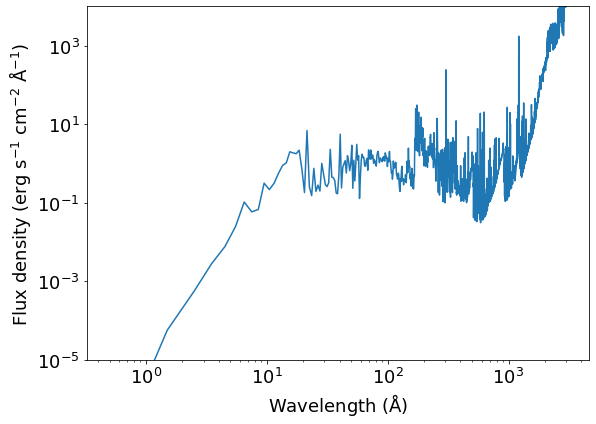

In [3]:
units = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
spectrum = tools.make_spectrum_from_file('../../data/solar_spectrum_scaled_lambda.dat',
                                    units)
plt.loglog(spectrum['wavelength'], spectrum['flux_lambda'])
plt.ylim(1E-5, 1E4)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.show()

Now we can calculate the distribution of ionized/neutral hydrogen. This involves calculating the differential equation 13 in [Oklopčić & Hirata (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...855L..11O/abstract). To achieve this, we start from an initial state at the innermost layer of the atmosphere and utilize the `hydrogen.ion_fraction()` function. It takes as input many of the parameters we already set above. 

**Notes on optional input parameters**:
* `initial_f_ion`: Value of H ion fraction at the surface of the planet. This is the initial state `y0` of the differential equation to be solved. The standard value for this parameter is `0.0`, i.e., completely neutral near the surface.
* `exact_phi`: If `False`, uses an approximation to calculates the photoionization of H. If `True`, then calculate the exact value.
* `relax_solution`: If `True`, then the mean molecular weight and the H ion fraction of the atmosphere are iteratively calculated until convergence to achieve self-consistency. If `False`, then the calculation is performed only once without updating the mean molecular weight. `False` is faster.
* `return_mu`: If `True`, then the function returns the resulting mean molecular weight (units of proton mass) in function of radial distance.

In [33]:
initial_f_ion = 0.0
r = np.logspace(0, np.log10(20), 100)  # Radial distance profile in unit of planetary radii
# r = np.linspace(1, 20, 100)

f_r, mu_bar = hydrogen.ion_fraction(r, R_pl, T_0, h_fraction, 
                            m_dot, M_pl, mu_0,
                            spectrum_at_planet=spectrum, exact_phi=True,
                            initial_f_ion=initial_f_ion, relax_solution=True,
                            return_mu=True)

And here's the result.

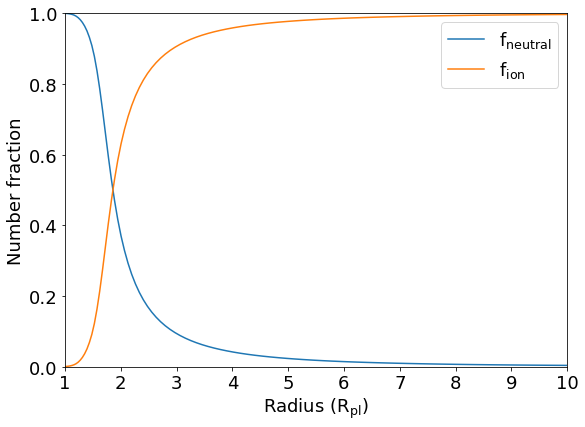

In [34]:
f_ion = f_r
f_neutral = 1 - f_r

plt.plot(r, f_neutral, color='C0', label='f$_\mathrm{neutral}$')
plt.plot(r, f_ion, color='C1', label='f$_\mathrm{ion}$')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number fraction')
plt.xlim(1, 10)
plt.ylim(0, 1)
plt.legend()
plt.show()

The next step is to calculate the structure of the planetary atmosphere in terms of densities and velocities.

**Note**: The velocities and densities calculated by `parker.structure()` are measured in units of sound speed and density at the sonic point, respectively.

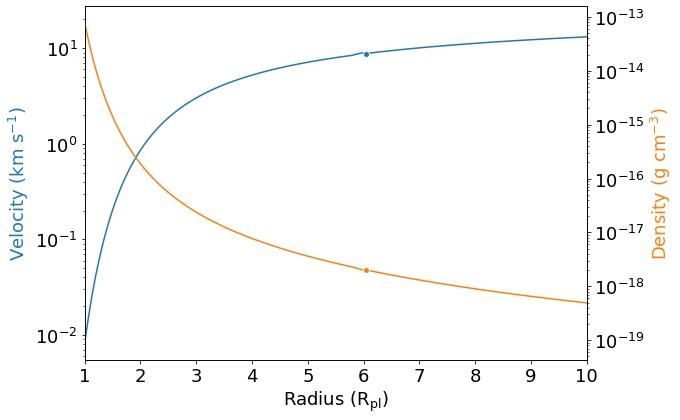

In [35]:
vs = parker.sound_speed(T_0, mu_bar)  # Speed of sound (km/s, assumed to be constant)
rs = parker.radius_sonic_point(M_pl, vs)  # Radius at the sonic point (jupiterRad)
rhos = parker.density_sonic_point(m_dot, rs, vs)  # Density at the sonic point (g/cm^3)

r_array = r * R_pl / rs
v_array, rho_array = parker.structure(r_array)

# Convenience arrays for the plots
r_plot = r_array * rs / R_pl
v_plot = v_array * vs
rho_plot = rho_array * rhos

# Finally plot the structure of the upper atmosphere
# The circles mark the velocity and density at the sonic point
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r_plot, v_plot, color='C0')
ax1.plot(rs / R_pl, vs, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r_plot, rho_plot, color='C1')
ax2.plot(rs / R_pl, rhos, marker='o', markeredgecolor='w', color='C1')
ax1.set_xlabel(r'Radius (R$_{\rm pl}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 10)
plt.show()

In the next step, we calculate the population of helium in singlet, triplet and ionized states using `helium.population_fraction()`. Similar to the hydrogen module, we integrate starting from the inner layer of the atmosphere.

In [37]:
# In the initial state, the fraction of singlet and triplet helium 
# are, respectively, 1.0 and 0.0
initial_state = np.array([0.1, 0.0])
f_he_1, f_he_3 = helium.population_fraction(
    r, v_array, rho_array, f_ion,
    R_pl, T_0, h_fraction, vs, rs, rhos, spectrum,
    initial_state=initial_state, relax_solution=False)

RuntimeError: The solver ``odeint`` failed to obtain a solution.

Finally, we plot the number densities of ionized helium, and helium in singlet and triplet states.

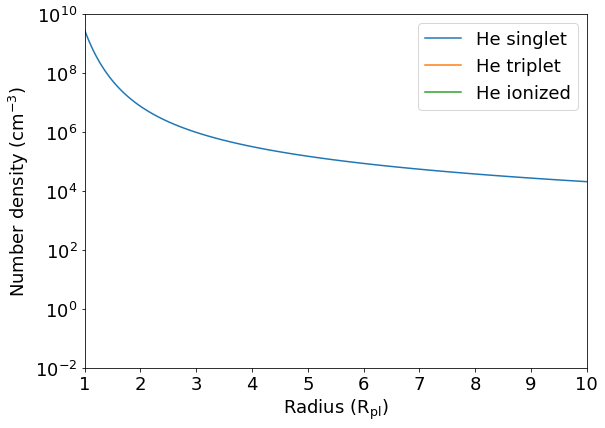

In [10]:
# Hydrogen atom mass
m_h = c.m_p.to(u.g).value

# Number density of helium nuclei 
he_fraction = 1 - h_fraction
n_he = (rho_array * rhos * he_fraction / (1 + 4 * he_fraction) / m_h)

n_he_1 = f_he_1 * n_he
n_he_3 = f_he_3 * n_he
n_he_ion = (1 - f_he_1 - f_he_3) * n_he

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-2, 1E10)
plt.legend()
plt.show()

Now that we have the 1-D profile of volumetric densities of the He triplet, we can calculate the spectroscopic transit signal using simplified ray tracing and radiative transfer. For now we will assume an impact factor of zero (so the planet is in the dead center of the star) and also a phase of zero (so the planet is at mid-transit phase). The phases of $-0.5$ and $+0.5$ correspond to the ingress and egress.

To this end, we use the function `transit.draw_transit()`, which takes several parameters that we calculated above as input (see the [documentation](https://p-winds.readthedocs.io/en/latest/api/transit.html) for more details) and returns four items in this order: 1) a 2-d normalized flux map for ray tracing (`numpy.ndarray`), 2) the transit depth of the opaque disk of the planet (`float`), a 2-d map of column densities (`numpy.ndarray`), and a 2-d map of radial velocities of the planetary wind (`numpy.ndarray`). All of them are used in the radiative transfer (except the transit depth, which taken into account automatically, but it is returned mostly for the user's book-keeping).

In [ ]:
# First convert everything to SI units because they make our lives
# much easier.
R_pl_physical = R_pl * 71492000  # Planet radius in m
r_SI = r * R_pl_physical  # Array of altitudes in m
v_SI = v_array * vs * 1000  # Velocity of the outflow in m / s
n_he_3_SI = n_he_3 * 1E6  # Volumetric densities in 1 / m ** 3
planet_to_star_ratio = 0.12086

# Set up the ray tracing. We will use a coarse 100-px grid size,
# but we use supersampling to avoid hard pixel edges.
flux_map, t_depth, r_from_planet = transit.draw_transit(
    planet_to_star_ratio, 
    planet_physical_radius=R_pl_physical, 
    impact_parameter=impact_parameter, 
    phase=0.0,
    supersampling=10,
    grid_size=100)

# And now we plot it just to check how the transit looks
plt.imshow(flux_map, origin='lower')
plt.show()

Next, we calculate the radiative transfer to estimate the spectroscopic signal in the He triplet. Since it is a triplet, we need to know the properties of the transitions. There is a handy function in the module ``microphysics`` that returns these properties.

We use the ``transit.radiative_transfer()`` function, which also takes a lot of parameters as input that we calculated above. Again we recommend you take a look at the [documentation](https://p-winds.readthedocs.io/en/latest/api/transit.html) to check all the possible inputs.

In [ ]:
# Retrieve the properties of the triplet; they were hard-coded
# using the tabulated values of the NIST database
# wX = central wavelength, fX = oscillator strength, a_ij = Einstein coefficient
w0, w1, w2, f0, f1, f2, a_ij = microphysics.he_3_properties()

m_He = 4 * 1.67262192369e-27  # Helium atomic mass in kg
wl = np.linspace(1.0827, 1.0832, 200) * 1E-6  # Wavelengths in m

# First, let's do the radiative transfer for each line of the triplet
# separately. Check the documentation to understand what are the
# input parameters, as there are many of them.

# Another important thing to have in mind is that the formal calculation
# of the radiative transfer can take a long time. To make it faster,
# there is an option that assumes something about the atmosphere
# and accelerates the modeling. That approximation is triggered by the
# `wind_broadening_method` input parameter set to `'average'`. If you want 
# to do the formal calculation, set `wind_broadening_method` to `'formal'`. 
# The default is `'average'`.
method = 'average'

spectrum_0 = transit.radiative_transfer_2d(flux_map, r_from_planet, 
                                        r_SI, n_he_3_SI, v_SI, w0, f0, a_ij,
                                        wl, T_0, m_He, wind_broadening_method=method)
spectrum_1 = transit.radiative_transfer_2d(flux_map, r_from_planet, 
                                        r_SI, n_he_3_SI, v_SI, w1, f1, a_ij,
                                        wl, T_0, m_He, wind_broadening_method=method)
spectrum_2 = transit.radiative_transfer_2d(flux_map, r_from_planet, 
                                        r_SI, n_he_3_SI, v_SI, w2, f2, a_ij,
                                        wl, T_0, m_He, wind_broadening_method=method)

# Finally let's calculate the combined spectrum of all lines in the triplet
# To do that, we combine all the line properties in their respective arrays
w_array = np.array([w0, w1, w2])
f_array = np.array([f0, f1, f2])
a_array = np.array([a_ij, a_ij, a_ij])  # This is the same for all lines in then triplet
spectrum = transit.radiative_transfer_2d(flux_map, r_from_planet, 
                                        r_SI, n_he_3_SI, v_SI, w_array, f_array, a_array,
                                        wl, T_0, m_He, wind_broadening_method=method)

plt.plot(wl * 1E6, spectrum_0, ls='--')
plt.plot(wl * 1E6, spectrum_1, ls='--')
plt.plot(wl * 1E6, spectrum_2, ls='--')
plt.plot(wl * 1E6, spectrum, color='k', lw=2)
plt.xlabel('Wavelength in air ($\mu$m)')
plt.ylabel('Normalized flux')
plt.show()

In case you don't have an input spectrum handy, you can also calculate ionization fractions of H and the He population using monochromatic fluxes at specific wavelength channels. The results will probably be a bit different from the ones calculated with a spectrum. Based on the solar spectrum arriving at HD 209458 b, a reasonable estimate of these fluxes is:

$f_{504} = 500$ erg/s/cm$^2$ (wavelength range to ionize He singlet, 0 - 504 Å)

$f_{911} = 1000$ erg/s/cm$^2$ (wavelength range to ionize H, 0 - 911 Å)

$f_\mathrm{uv} = 5 \times 10^6$ erg/s/cm$^2$ (wavelength range to ionize He triplet, 911 - 2593 Å)

In [ ]:
f504 = 500 #* u.erg / u.s / u.cm ** 2
f911 = 1000 #* u.erg / u.s / u.cm ** 2
fuv = 5E6 #* u.erg / u.s / u.cm ** 2

# We compute `f_ion` from 1 to 15 planetary radii
r = np.linspace(1.0, 20, 500)
initial_f_ion = 0.0

f_r = hydrogen.ion_fraction(r, R_pl, T_0, h_fraction, 
                            m_dot, M_pl, mean_f_ion,
                            flux_euv=f911,
                            initial_f_ion=initial_f_ion, relax_solution=True)

f_ion = f_r
f_neutral = 1 - f_r

plt.plot(r, f_neutral, color='C0', label='f$_\mathrm{neutral}$')
plt.plot(r, f_ion, color='C1', label='f$_\mathrm{ion}$')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('H number fraction')
plt.xlim(1, 10)
plt.ylim(0, 1)
plt.legend()
plt.show()

Finally, we calculate the helium population with the monocromatic fluxes.

In [ ]:
mean_f_ion = np.mean(f_ion)

vs = parker.sound_speed(T_0, h_fraction, mean_f_ion)
rs = parker.radius_sonic_point(M_pl, vs)
rhos = parker.density_sonic_point(m_dot, rs, vs)

r_array = r * R_pl / rs
v_array, rho_array = parker.structure(r_array)

initial_state = np.array([1.0, 0.0])
f_he_1, f_he_3 = helium.population_fraction(
    r, v_array, rho_array, f_ion,
    R_pl, T_0, h_fraction, vs, rs, rhos, flux_euv=f504, flux_fuv=fuv,
    initial_state=initial_state, relax_solution=True)

# Number density of helium nuclei
n_he = (rho_array * rhos * he_fraction / (1 + 4 * he_fraction) / m_h)

n_he_1 = f_he_1 * n_he
n_he_3 = f_he_3 * n_he
n_he_ion = (1 - f_he_1 - f_he_3) * n_he

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-2, 1E10)
plt.legend()
plt.show()